## Algorithme pour l'analyse de la stabilité de la discrétisation de l'équation de diffusion en 1 dimension.

Tout d'abord, on importe les modules Python pertinents.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sqlite3
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sys
import datetime, os
from sklearn import metrics
from sklearn import preprocessing
from time import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.python.keras.callbacks import TensorBoard

import os

Ici, on importe les données contenues dans les fichiers "db.db" et "db_diffusion_1D_4.db" pour les fussioner après dans un même objet.

      tmax     alpha        dx        dt  stable  nb_iteration         erreur
7495   500  0.000235  0.010582  0.233290       1          2143   8.190000e-04
7496   500  0.000235  0.010582  0.242621       0          2060   4.866662e+26
7497   500  0.000235  0.010582  0.251953       0          1984   1.988704e+88
7498   500  0.000235  0.010582  0.261284       0          1913  2.404208e+141
7499   500  0.000235  0.010582  0.270616       0          1847   1.000000e+07


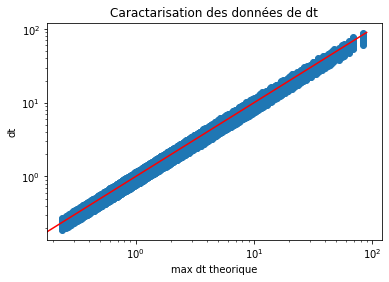

In [2]:
columns=['tmax','alpha','dx','dt','stable','nb_iteration','erreur']
#os.chdir('/Users/rachadi/Desktop/machine learning PE')
cnx1 = sqlite3.connect('db_final.db')
raw_dataset1 = pd.read_sql_query("SELECT * FROM db_diffusion1D_", cnx1)

data = raw_dataset1.copy()
data.columns=['tmax','alpha','dx','dt','stable','nb_iteration','erreur']
print(data.tail())
X=(data['dx']*data['dx'])/(2*data['alpha'])
Y=data['dt']
identity = np.linspace(0,90)
plt.scatter(X.values,Y.values)
plt.plot(identity,identity,'r')
plt.title('Caractarisation des données de dt')
plt.xlabel('max dt theorique')
plt.ylabel('dt')
plt.xscale('log')
plt.yscale('log')

Dans la suite, on applique un filtrage des données pour n'obtenir que les données pour lesquelles la simulation est stable. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750 entries, 3595 to 4957
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   alpha   750 non-null    float64
 1   dx      750 non-null    float64
 2   dt      750 non-null    float64
dtypes: float64(3)
memory usage: 23.4 KB


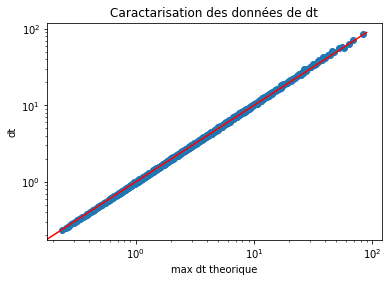

In [3]:
data_stable = data[data['stable'] == 1]

index_dt_optimal = data_stable.groupby(['alpha','dx'])['nb_iteration'].agg(pd.Series.idxmin)
data_stable_optimal = data_stable.filter(items = index_dt_optimal.values, axis = 0)

data_stable_optimal.tail()

data_stable_optimal_clean=data_stable_optimal.drop(['stable','nb_iteration','erreur', 'tmax'],axis=1)
data_stable_optimal_clean.info()
X=(data_stable_optimal_clean['dx']*data_stable_optimal_clean['dx'])/(2*data_stable_optimal_clean['alpha'])
Y=data_stable_optimal_clean['dt']
plt.scatter(X.values,Y.values)
plt.plot(identity,identity,'r')
plt.title('Caractarisation des données de dt')
plt.xlabel('max dt theorique')
plt.ylabel('dt')

Avant de normaliser les données, on sauvegardera les paramètres statistiques principaux pour l'étude de la base de données. Ces données sont sauvegardées dans le fichier *db_synthese.txt*, où les colonnes correspondent à alpha, dx et dt respectivement.

In [75]:
maxvals = data_stable_optimal_clean.max(axis=0).values
minvals = data_stable_optimal_clean.min(axis=0).values
meanvals = data_stable_optimal_clean.mean(axis=0).values
stdvals = data_stable_optimal_clean.std(axis=0).values

synthese = np.array([maxvals, minvals, meanvals, stdvals])
content = str(synthese)
fichier = open("db_synthese.txt","w+")
fichier.write(content)
fichier.close()

fichier = open("db_synthese.txt","r")
print(fichier.read())

[[2.35000000e-04 4.08160000e-02 8.61207230e+01]
 [1.00000000e-05 1.05820000e-02 2.33290000e-01]
 [7.37000000e-05 1.97552667e-02 6.02955241e+00]
 [5.61231659e-05 8.71204326e-03 9.26374808e+00]]


On normalise les données en utilisant des méthodes inclues dans le module SciKitLearn.

        alpha        dx        dt
745  2.875954  0.312045 -0.535855
746  2.875954  0.638707 -0.505587
747  2.875954  1.060244 -0.461648
748  2.875954  1.624438 -0.384484
749  2.875954  2.419041 -0.269587


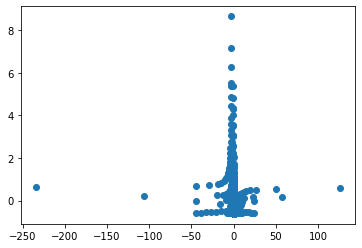

In [76]:
x=data_stable_optimal_clean.values
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
data_stable_optimal_clean = pd.DataFrame(x_scaled)
data_stable_optimal_clean.columns = ['alpha','dx','dt']
print(data_stable_optimal_clean.tail())
X=(data_stable_optimal_clean['dx']*data_stable_optimal_clean['dx'])/(2*data_stable_optimal_clean['alpha'])
Y=data_stable_optimal_clean['dt']
plt.scatter(X.values,Y.values)
plt.xscale('log')
plt.yscale('log')

On divise les données en une base d'entraînement, qui contient 75% des données, et une base de test, qui contient le reste.

In [77]:
train_dataset = data_stable_optimal_clean.sample(frac=0.8,random_state=0)
test_dataset = data_stable_optimal_clean.drop(train_dataset.index)
#print(test_dataset.tail())
train_labels = train_dataset.pop('dt')
test_labels = test_dataset.pop('dt')
#print(test_labels.tail() )
train_labels = np.asarray(train_labels)
test_labels = np.asarray(test_labels)
train_dataset = np.asarray(train_dataset)
test_dataset = np.asarray(test_dataset)

Ici on défine la fonction du réseau, avec 3 couches de 5 neurones, qui donne en total 81 degrés de liberté

In [78]:
def build_model():
    model = keras.Sequential()
    model.add(layers.Dense(5,use_bias=True,input_shape=[train_dataset.shape[1]]))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.Dense(20,use_bias=True,input_shape=[train_dataset.shape[1]]))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.Dense(20,use_bias=True,input_shape=[train_dataset.shape[1]]))
    model.add(LeakyReLU(alpha=0.1))
    model.add(layers.Dense(1,use_bias=True,activation='linear'))

    return model

model = build_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 5)                 15        
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 5)                 0         
_________________________________________________________________
dense_33 (Dense)             (None, 20)                120       
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 20)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 20)                420       
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 20)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                

Ici la définition de la fonction d'optimisation pour le réseau. D'après nos essais, avec 1000 epoches, la courbe de résidu atteint son asymptote.

In [79]:
def train_model():
  
    
  optimizer = tf.optimizers.Adam() #

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])

  early_stop = keras.callbacks.EarlyStopping(monitor='val_mse',min_delta=1e-17, patience=10)
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1,profile_batch=0)


  model.fit(train_dataset, 
            train_labels, 
            epochs=7000,
            batch_size=1000,
            validation_split = 0.5, 
            verbose=0, 
            callbacks=[early_stop,tensorboard_callback])
    
  
example_batch = train_dataset[:10]
example_result = model.predict(example_batch)
print(example_result)
print(example_batch)

[[-0.00185215]
 [ 0.08695601]
 [ 0.00338306]
 [ 0.14839453]
 [-0.01718409]
 [-0.01449241]
 [-0.13556013]
 [ 0.00844341]
 [ 0.04155744]
 [ 0.08871679]]
[[ 0.05883849  0.0513119 ]
 [-0.93963282 -0.16152412]
 [-0.54737623  0.63870714]
 [-1.08227158 -0.98576116]
 [ 0.29062647 -0.16152412]
 [ 0.23713694 -0.3386386 ]
 [ 2.60850629 -1.05364356]
 [-1.13576111  2.41904077]
 [ 0.05883849 -0.82426767]
 [-0.8148239  -0.3386386 ]]


Entraînement du modèle.

In [80]:
train_model()
model.save("diffusion1D_modele_entraine_more_neurons_4.h5")

Par la suite, on affiche les résultats d'entraînement du réseau par rapport à la base de test.

In [81]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features).flatten()
    #R2
    R2=metrics.r2_score(test_labels, predictions)
    #Correlation entre predictions et vraies donnees
    Correl=np.corrcoef(test_labels, predictions)[0, 1]
    print('Model Performance:')
    print('Correlation: {:0.4f}.'.format(Correl))
    print('R2: {:0.4f}.'.format(R2))

In [82]:
def visualize(model, test_features, test_labels):
    X_test=test_labels
    Y_pred=model.predict(test_features).flatten()
    Y_test=test_labels
    plt.scatter(Y_test,Y_pred, color = 'red',marker=".")
    plt.scatter(Y_test,Y_test, color = 'black',marker=".")
    plt.title('ANN Regression Results')
    plt.xlabel('dt_exact')
    plt.ylabel('dt_model')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

Model Performance:
Correlation: 0.9982.
R2: 0.9963.


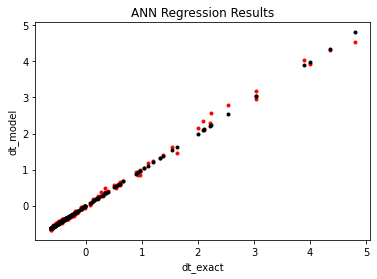

[[-1.13576111  0.0513119 ]
 [-1.13576111  0.63870714]
 [-1.10010142 -0.72732564]
 [-1.10010142 -0.16152412]
 [-1.10010142  1.62443767]
 [-1.08227158 -0.90983855]
 [-1.08227158 -0.48830149]
 [-1.08227158  0.63870714]
 [-1.08227158  1.0602442 ]
 [-1.08227158  1.62443767]
 [-1.04661189 -0.90983855]
 [-1.04661189 -0.16152412]
 [-1.04661189  1.0602442 ]
 [-1.04661189  1.62443767]
 [-1.02878204  0.31204463]
 [-1.02878204  1.0602442 ]
 [-0.99312235 -0.61648551]
 [-0.99312235 -0.3386386 ]
 [-0.99312235  0.0513119 ]
 [-0.99312235  0.63870714]
 [-0.99312235  1.0602442 ]
 [-0.97529251 -0.98576116]
 [-0.97529251 -0.72732564]
 [-0.97529251 -0.61648551]
 [-0.97529251 -0.16152412]
 [-0.97529251  0.0513119 ]
 [-0.93963282  0.31204463]
 [-0.93963282  2.41904077]
 [-0.92180297 -0.82426767]
 [-0.92180297 -0.16152412]
 [-0.92180297  0.31204463]
 [-0.92180297  0.63870714]
 [-0.88614328 -0.72732564]
 [-0.88614328 -0.16152412]
 [-0.88614328  1.0602442 ]
 [-0.88614328  1.62443767]
 [-0.86831344 -0.98576116]
 

In [83]:
evaluate(model,test_dataset,test_labels)
visualize(model,test_dataset,test_labels)
print(test_dataset)
print(test_labels)

In [84]:
%reload_ext tensorboard
%tensorboard --logdir logs

###%tensorboard dev upload --logdir \'logs'
### Dans Anaconda Prompt
### cd C:\Users\jonat\Git\PE-001\Private\Jupyter_notebook\Pull corr\Diffusion1D
### tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 6724), started 0:16:59 ago. (Use '!kill 6724' to kill it.)